In [1]:
from VQALib import IsingHamiltonian
from VQATests import tests

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from collections import Counter

from VQALib import CubicProgram, IsingHamiltonian

from qiskit.visualization import plot_histogram

# ------------ GRAPH FUNCTIONS -----------
def draw_graph(G, colors, pos, ax=None):
    default_axes = plt.axes(frameon=True) if ax is None else ax
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def compute_matrix(n, G):
    # Computing the weight matrix from the random graph
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = 1
    return w

def color_graph(bitstring, n, m, H, posH, ax=None):
    #print(bitstring)
    colors = ["r" for node in range(m)]
    for k in range(n*m):
        i = k // m  # Integer division to retrieve the i value
        j = k % m   # Modulus operation to retrieve the j value
        if bitstring[k] == 1:
            #print(f"coloring {j}!")
            colors[j] = "b"
    draw_graph(H, colors, posH, ax)

def create_graph(n, elistG, m, elistH):
    # Target graph:
    H = nx.DiGraph()
    H.add_nodes_from(np.arange(0, m, 1))
    H.add_edges_from(elistH)
    colorsH = ["r" for node in H.nodes()]
    posH = nx.spring_layout(H)

    # Pattern graph:
    G = nx.DiGraph()
    G.add_nodes_from(np.arange(0, n, 1))
    G.add_edges_from(elistG)
    colorsG = ["r" for node in G.nodes()]
    posG = nx.spring_layout(H)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    draw_graph(G, colorsG, posG, axes[0])
    draw_graph(H, colorsH, posH, axes[1])
    plt.tight_layout()
    plt.show()

    return G, colorsG, posG, H, colorsH, posH

# ------------ ARITHMETIC FUNCTIONS ------
def expand_arithmetic_function(mat1, mat2, n, m):
    linear = []
    quadratic = []
    cubic = []

    penalty = n

    def translate(i, j):
        return (i*m+j)

    # FIRST TERM:
    sum = 0
    for i in range(n):
        for u in range(m):
            linear.append((translate(i, u), -1))

    # SECOND TERM (EXPANDED):
    sum2 = 0
    for v in range(m):
        inner = 0
        for i in range(n):
            for k in range(n):
                quadratic.append( ( (translate(i, v), translate(k, v) ), 1) )   # ( (var1, var2),  coeff )
        
        for i in range(n):
            linear.append((translate(i, v), -1))
    

    sum2 = 0
    # THIRD TERM (CHECKS THAT NUMBER OF OUTGOING EDGES OF EACH VERTEX U IS EQUAL TO OUTGOING EDGES OF EACH VERTEX I):
    for u in range(m):
        for i in range(n):
            for j in range(n):
                # Add the linear terms:
                linear.append((translate(i, u), penalty*mat1[i][j]*mat1[i][j]))

                for v in range(m):
                    # Add quadratic terms:
                    quadratic.append( ( (translate(j,v), translate(i, u) ), -1*2*penalty*mat1[i][j]*mat2[u][v]) )
                
                for v in range(m):
                    for k in range(m):
                        # Add cubic terms:
                        cubic.append( ( ( translate(j,v), translate(j, k), translate(i,u) ), penalty*mat2[u][v]*mat2[u][k] ) )
            

    # FOURTH TERM (CHECKS THAT NUMBER OF INCOMING EDGES OF EACH VERTEX U IS EQUAL TO OUTGOING EDGES OF EACH VERTEX I):
    for u in range(m):
        for i in range(n):
            for j in range(n):
                # Add the linear terms:
                linear.append((translate(i, u), penalty*mat1[j][i]*mat1[j][i]))

                for v in range(m):
                    # Add quadratic terms:
                    quadratic.append( ( (translate(j,v), translate(i, u) ), -1*2*penalty*mat1[j][i]*mat2[v][u]) )
                
                for v in range(m):
                    for k in range(m):
                        # Add cubic terms:
                        cubic.append( ( ( translate(j,v), translate(j, k), translate(i,u) ), penalty*mat2[v][u]*mat2[k][u] ) )
    
    return linear, quadratic, cubic

def clean_coefficients(linear, quadratic, cubic):
    """Removes all the terms with coefficient 0 from the function.

    Args:
        linear (_type_): linear terms
        quadratic (_type_): quadratic_terms
        cubic (_type_): cubic terms
    """    
    def drop(list):
        to_remove = []
        for idx, (term, coeff) in enumerate(list):
            if coeff == 0:
                to_remove.append((term, coeff))
        
        for item in to_remove:
            list.remove(item)
        return list
    
    linear = drop(linear)
    quadratic = drop(quadratic)
    cubic = drop(cubic)
    
    return linear, quadratic, cubic

def collect_terms(linear, quadratic, cubic):
    """Sums all identical terms together to reduce function to strictly unique terms with real coefficient.
    """    
    def combine(tuple_list):
        combined_tuples = {}
        
        for tpl, coeff in tuple_list:
            # Convert the tuple to a hashable format using sorted tuple of its Counter elements
            if isinstance(tpl, int):
                tpl = (tpl,)
            hashable_tpl = tuple(sorted(Counter(tpl).items()))
            # Check if the hashable tuple already exists in the dictionary
            if hashable_tpl in combined_tuples:
                # Accumulate the coefficient for the existing tuple
                combined_tuples[hashable_tpl] += coeff
            else:
                # Create a new entry in the dictionary
                combined_tuples[hashable_tpl] = coeff
        
        # Convert the dictionary back to the original format of list of tuples
        reduced_list = [( tuple(x for x, count in dict_key for _ in range(count)) , coeff) for dict_key, coeff in combined_tuples.items()]
        
        return reduced_list

    
    collected_linear_terms = combine(linear)
    collected_quadratic_terms = combine(quadratic)
    collected_cubic_terms = combine(cubic)

    return collected_linear_terms, collected_quadratic_terms, collected_cubic_terms

def produce_terms_from_graphs(mat1, mat2, n, m):
    linear, quadratic, cubic = expand_arithmetic_function(mat1, mat2, n, m)
    linear, quadratic, cubic = clean_coefficients(linear, quadratic, cubic)
    linear, quadratic, cubic = collect_terms(linear, quadratic, cubic)
    #print(f"Size: {len(linear)}, linear terms: {linear}")
    #print(f"Size: {len(quadratic)}, quadratic terms: {quadratic}")
    #print(f"Size: {len(cubic)}, cubic terms: {cubic}")
    return linear, quadratic, cubic

def produce_cubic_problem_from_graph(n, elistG, m, elistH):
    G, colorsG, posG, H, colorsH, posH = create_graph(n, elistG, m, elistH)
    linear, quadratic, cubic = produce_terms_from_graphs(compute_matrix(n, G), compute_matrix(m, H), n, m)
    cubic_instance = CubicProgram(linear, quadratic, cubic, n*m)
    return cubic_instance, n, m, H, posH

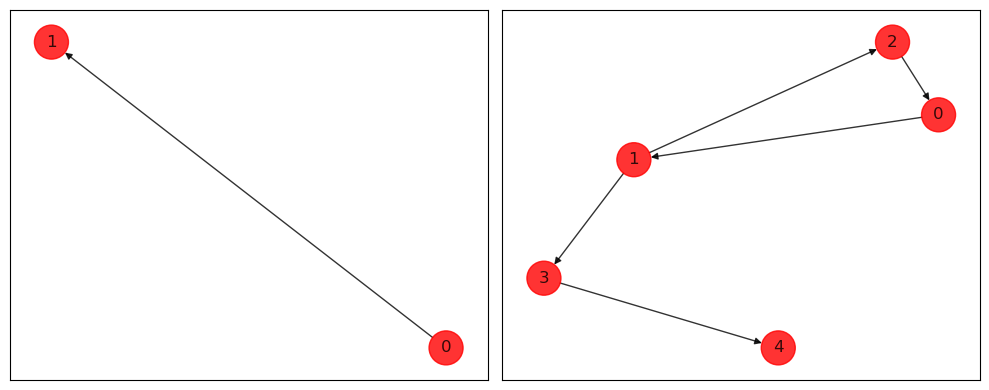

Most Common Pair: (2, 3)
Sublist with Common Pair: [((1, 2, 3), 4.0), ((2, 3, 6), 4.0)]
Remaining true cubics: [((1, 7, 8), 4.0), ((6, 7, 8), 4.0)]
Most Common Pair: (7, 8)
Sublist with Common Pair: [((1, 7, 8), 4.0), ((6, 7, 8), 4.0)]
Remaining true cubics: []
New number of variable: 12
Introduced an additional 2 qubits...


In [6]:
test_pkg = tests()
problem = test_pkg.problems[10][2]

n = problem['n']
m = problem['m']
elistG = problem['elistG']
elistH = problem['elistH']
cubic_instance, n, m, H, posH = produce_cubic_problem_from_graph(n, elistG, m, elistH)
cubic_instance.reduce_cubic()
hamiltonian = IsingHamiltonian(cubic_instance)

0


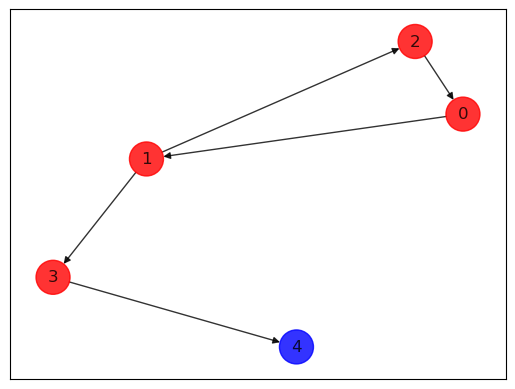

In [7]:
correct_bitstrings = problem['correct_bitstrings']
likeliest_bitstring, highest_probability, overlap = hamiltonian.run_VQE(correct_bitstrings, depth=5)
counts = hamiltonian.counts

print(overlap)
color_graph(likeliest_bitstring, n, m, H, posH)